In [1]:
import pickle
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.8"

from jax.config import config
#config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm, trange

from itertools import product
import functools
import awkward as ak
import pandas as pd
from hyperion.constants import Constants
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_source import PhotonSource, PhotonSourceType
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood_per_module
from olympus.event_generation.photon_propagation.utils import sources_to_model_input_per_module, sources_to_array
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source
from olympus.event_generation.utils import sph_to_cart_jnp
from hyperion.utils import (
    make_cascadia_abs_len_func,
    cherenkov_ang_dist,
    cherenkov_ang_dist_int,
)


from hyperion.pmt.pmt import make_calc_wl_acceptance_weight
from hyperion.medium import medium_collections, make_mixed_scattering_func, rayleigh_scattering_angle, henyey_greenstein_scattering_angle

from hyperion.constants import Constants



import jax
from jax import jit, random
from jax import numpy as jnp

import json

%matplotlib inline


In [2]:
path_to_config = "data/pone_config.json"
config = json.load(open(path_to_config))["photon_propagation"]
ref_ix_f, sca_a_f, sca_l_f = medium_collections[config["medium"]]
abs_len = make_cascadia_abs_len_func(sca_l_f)


def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / ref_ix_f(wl)

pmtacc = np.loadtxt("data/PMTAcc.csv", delimiter=",")

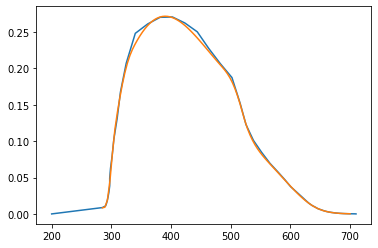

In [3]:
wl_acc = make_calc_wl_acceptance_weight("data/PMTAcc.csv")

wls = np.linspace(285, 700, 100)
plt.plot(pmtacc[:, 0], pmtacc[:, 1])
plt.plot(wls, wl_acc(wls, 0.27))

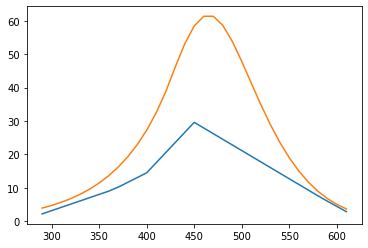

In [4]:
absLenTable = [  2.215,   3.186,   4.158,   5.129,   6.100,   7.072,   8.043,   9.014,   10.214,
                    11.643,  13.071,  14.500,  17.520,  20.540,  23.560,  26.580,  29.600,   27.911,
                    26.222,  24.533,  22.844,  21.156,  19.467,  17.778,  16.089,  14.400,   12.711,
                    11.022,   9.333,   7.644,   6.017,   4.450,   2.884]

wlens = np.arange(290, 620, 10)

plt.plot(wlens, absLenTable)
plt.plot(wlens, abs_len(wlens))

In [6]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1E4 * 1E-9  # 1/ns

gen_ph = make_generate_norm_flow_photons(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    c_medium=c_medium_f(700) / 1E9
   
)

lh_per_mod = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
))

lh_per_mod_split = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    split_shape_counts=True
))


evlh = jax.vmap(lh_per_mod, in_axes=[0, 0, None, None, None, None, None, 0])

def eval_for_mod_split(x, y, z, theta, phi, t, log10e, times, mod_coords, noise_rate, key):

    pos = jnp.asarray([x, y, z])
    dir = sph_to_cart_jnp(theta, phi)

    #sources = make_realistic_cascade_source(pos, t, dir, 10**log10e, 11, resolution=0.5, key=key, moliere_rand=True)
    sources = make_pointlike_cascade_source(pos, t, dir, 10**log10e, 11)

    return lh_per_mod_split(
        times,
        mod_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9, noise_rate
    )

eval_for_mod_split_jit = jax.jit(eval_for_mod_split)

def eval_for_mod(x, y, z, theta, phi, t, log10e, times, mod_coords, noise_rate, key):

    pos = jnp.asarray([x, y, z])
    dir = sph_to_cart_jnp(theta, phi)

    sources = make_realistic_cascade_source(pos, t, dir, 10**log10e, 11, resolution=0.5, key=key, moliere_rand=True)
    #sources = make_pointlike_cascade_source(pos, t, dir, 10**log10e, 11)

    return lh_per_mod(
        times,
        mod_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9, noise_rate
    )




In [7]:
clsim_events, clsim_geo, thetas, phis, (wlens, refix, scalen), sca_ang_samples = pickle.load(open("data/clsim_photons_extracted.pickle", "rb"))



In [8]:
sca_fun = make_mixed_scattering_func(
        rayleigh_scattering_angle,
        lambda k: henyey_greenstein_scattering_angle(k, 0.95742038),
        0.12773887,
)
sca_a_f_v = jax.vmap(sca_fun, in_axes=[0])
sca_ang_samples_hyp = np.cos(sca_a_f_v(random.split(random.PRNGKey(0), 100000)))

(0.8, 1.0)

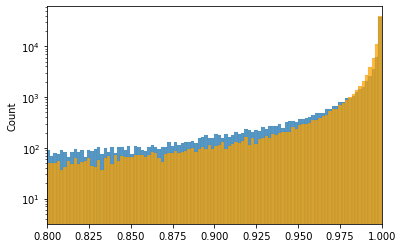

In [9]:

sns.histplot(sca_ang_samples, bins=np.linspace(-1, 1, 1000))
sns.histplot(sca_ang_samples_hyp, bins=np.linspace(-1, 1, 1000), color="orange")
plt.semilogy()
plt.xlim(0.8, 1)

In [10]:
from scipy.stats import ks_2samp
from scipy.optimize import fmin_l_bfgs_b

gs = np.linspace(0.8, 0.97, 20)

def obj_fun(params):
    g, m = params
    sca_fun = make_mixed_scattering_func(
        rayleigh_scattering_angle,
        lambda k: henyey_greenstein_scattering_angle(k, g),
        m,
    )
    sca_a_f_v = jax.vmap(sca_fun, in_axes=[0])
    sca_ang_samples_hyp = np.cos(sca_a_f_v(random.split(random.PRNGKey(0), 100000)))
    print(ks_2samp(sca_ang_samples, sca_ang_samples_hyp))
    return ks_2samp(sca_ang_samples, sca_ang_samples_hyp).statistic

res = fmin_l_bfgs_b(obj_fun, [0.95, 0.15], approx_grad=True, bounds=((0.8, 0.97), (0.01, 0.2)), epsilon=1E-3)


KstestResult(statistic=0.14605, pvalue=0.0)
KstestResult(statistic=0.14364, pvalue=0.0)
KstestResult(statistic=0.14611000000000007, pvalue=0.0)
KstestResult(statistic=0.21333000000000002, pvalue=0.0)
KstestResult(statistic=0.20784000000000002, pvalue=0.0)
KstestResult(statistic=0.21252, pvalue=0.0)
KstestResult(statistic=0.13552999999999993, pvalue=0.0)
KstestResult(statistic=0.13280999999999998, pvalue=0.0)
KstestResult(statistic=0.13564999999999994, pvalue=0.0)
KstestResult(statistic=0.15236, pvalue=0.0)
KstestResult(statistic=0.15710999999999997, pvalue=0.0)
KstestResult(statistic=0.15165, pvalue=0.0)
KstestResult(statistic=0.1285900000000001, pvalue=0.0)
KstestResult(statistic=0.12575999999999998, pvalue=0.0)
KstestResult(statistic=0.12865000000000004, pvalue=0.0)
KstestResult(statistic=0.1391, pvalue=0.0)
KstestResult(statistic=0.14333, pvalue=0.0)
KstestResult(statistic=0.13821, pvalue=0.0)
KstestResult(statistic=0.12597000000000003, pvalue=0.0)
KstestResult(statistic=0.123579999

In [11]:
clsim_tfirst = []
hyperion_tfirst = []
clsim_amp = []
hyperion_amp = []
omkey = 1
uq_thetas = np.unique(thetas)

for theta in uq_thetas:
    #theta = uq_thetas[45]
    theta_ix = np.argwhere(thetas == theta).ravel()

    phi = np.asarray(phis)[theta_ix][0]
    if ~np.isfinite(phi):
        phi = 0


    all_times = []
    all_weights = []
    all_ph_thetas = []
    for (times, weights, ph_thetas) in clsim_events:
        if omkey not in times:
            all_times.append([])
            all_weights.append([])
            all_ph_thetas.append([])
        else:
            all_times.append(times[omkey])
            all_weights.append(weights[omkey])
            all_ph_thetas.append(ph_thetas[omkey])

    all_times = np.asarray(all_times)
    all_weights = np.asarray(all_weights)
    all_ph_thetas = np.asarray(all_ph_thetas)

    sel_times = np.concatenate(all_times[theta_ix])
    sel_weights = np.concatenate(all_weights[theta_ix])
    sel_ph_thetas = np.concatenate(all_ph_thetas[theta_ix])

    tgeo = np.linalg.norm(clsim_geo[omkey] - np.asarray([0, 0, 0])) / c_medium_f(700) * 1E9

    event_data = {"t0": 0., "theta": theta, "phi": np.radians(0), "pos": np.asarray([0, 0, 0.]), "energy": 1E5, "pid": 11}
    event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])

    eval_times = jnp.linspace(tgeo - 10, tgeo+50, 60)
    shape_lh, counts_lh, n_pred = eval_for_mod_split(
            event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], theta,
            event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
            eval_times, jnp.asarray(clsim_geo[omkey]), 1E-6, random.PRNGKey(0)
    )
    hyperion_amp.append(n_pred)

    clsim_tfirst.append(np.min(sel_times))
    hyperion_tfirst.append(eval_times[jnp.argmax(shape_lh).ravel()])
    clsim_amp.append(np.sum(sel_weights)/10)




/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

-1.0


[]

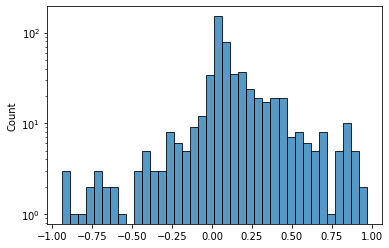

In [12]:
print(np.cos(theta))
sns.histplot(np.cos(sel_ph_thetas))
plt.semilogy()

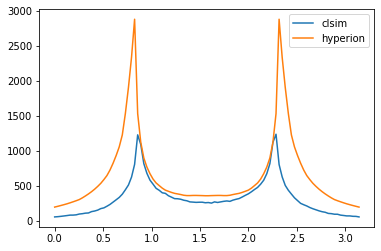

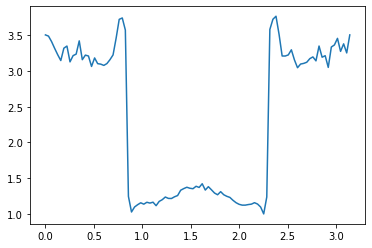

In [13]:
plt.plot(uq_thetas, clsim_amp, label="clsim")
plt.plot(uq_thetas, hyperion_amp, label="hyperion")
plt.legend()

plt.figure()
plt.plot(uq_thetas, np.asarray(hyperion_amp)/np.asarray(clsim_amp), label="hyperion")

Text(0, 0.5, 'Number of Photons')

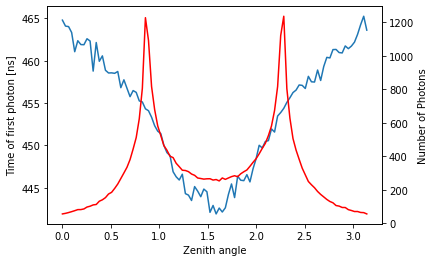

In [14]:
plt.plot(uq_thetas, clsim_tfirst, label="clsim")
plt.ylabel("Time of first photon [ns]")
plt.xlabel("Zenith angle")
ax2 = plt.gca().twinx()
ax2.plot(uq_thetas, clsim_amp, label="clsim", color="r")
#plt.plot(uq_thetas, hyperion_tfirst, label="clsim")

ax2.set_ylabel("Number of Photons")


#plt.axhline(tgeo, color="k", ls="--")

/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646:

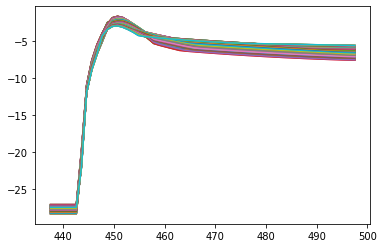

In [15]:
for theta in uq_thetas:
    shape_lh, counts_lh, n_pred = eval_for_mod_split(
            event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], theta,
            event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
            eval_times, jnp.asarray(clsim_geo[omkey]), 1E-6, random.PRNGKey(0)
    )

    plt.plot(eval_times, shape_lh)

In [19]:
uq_thetas[28]

0.8885312555607494

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the f

[]

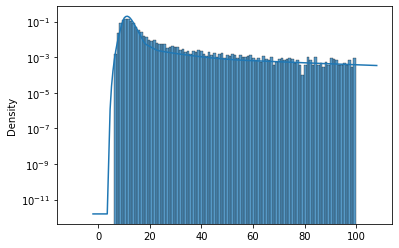

In [17]:
theta = uq_thetas[28]
theta_ix = np.argwhere(thetas == theta).ravel()

phi = np.asarray(phis)[theta_ix][0]
if ~np.isfinite(phi):
    phi = 0


all_times = []
all_weights = []
all_ph_thetas = []
for (times, weights, ph_thetas) in clsim_events:
    all_times.append(times[omkey])
    all_weights.append(weights[omkey])
    all_ph_thetas.append(ph_thetas[omkey])

all_times = np.asarray(all_times)
all_weights = np.asarray(all_weights)
all_ph_thetas = np.asarray(all_ph_thetas)

sel_times = np.concatenate(all_times[theta_ix])
sel_weights = np.concatenate(all_weights[theta_ix])
sel_ph_thetas = np.concatenate(all_ph_thetas[theta_ix])

tgeo = np.linalg.norm(clsim_geo[omkey] - np.asarray([0, 0, 0])) / c_medium_f(700) * 1E9

event_data = {"t0": 0., "theta": theta, "phi": np.radians(0), "pos": np.asarray([0, 0, 0.]), "energy": 1E5, "pid": 11}
event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])

eval_times = jnp.linspace(tgeo - 10, tgeo+100, 200)
shape_lh, counts_lh, n_pred = eval_for_mod_split(
        event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], theta,
        event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
        eval_times, jnp.asarray(clsim_geo[omkey]), 1E-6, random.PRNGKey(0)
)
hyperion_amp.append(n_pred)

clsim_tfirst.append(np.min(sel_times))
hyperion_tfirst.append(eval_times[jnp.argmax(shape_lh).ravel()])
clsim_amp.append(np.sum(sel_weights)/10)
bins = np.linspace(-10, 100, 110)
sns.histplot(x=sel_times - tgeo, weights=sel_weights, bins=bins, stat="density")
plt.plot(eval_times-tgeo+ 8, np.exp(shape_lh))
plt.semilogy()


In [36]:
wl_acc = make_calc_wl_acceptance_weight("data/DOMEfficiency.dat")
det_ph = pickle.load(open("data/photon_table_25.pickle", "rb"))[0]


In [37]:
det_ph["dist"]

73.43139224077271

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

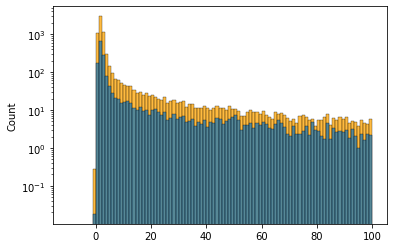

In [38]:
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

abs_len = make_cascadia_abs_len_func(sca_len_func_antares)
prop_dist = det_ph["times_det"] * c_medium_f(det_ph["wavelengths"])/1E9 
abs_weight = np.exp(-prop_dist / abs_len(det_ph["wavelengths"]))
wl_weight = wl_acc(det_ph["wavelengths"], 0.28)
c_weight = (
                cherenkov_ang_dist(
                    np.cos(det_ph["emission_angles"] - 0), n_ph=cascadia_ref_index_func(det_ph["wavelengths"])
                )
                / cherenkov_ang_dist_int(cascadia_ref_index_func(det_ph["wavelengths"]), -1, 1)
                * 2
            )
total_weight = abs_weight * wl_weight * c_weight

bins = np.linspace(-10, 100, 100)

tres = det_ph["times_det"] - det_ph["dist"] / c_medium_f(700)*1E9
sns.histplot(x=tres, bins = bins, weights=abs_weight, color="orange")
sns.histplot(x=tres, bins = bins, weights=total_weight)

plt.semilogy()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

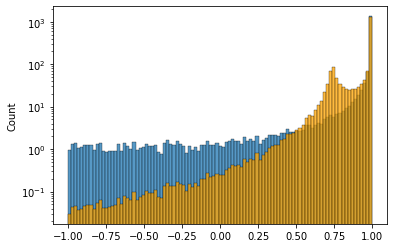

In [39]:
sns.histplot(x=np.cos(det_ph["emission_angles"]), weights= abs_weight * wl_weight, bins=np.linspace(-1, 1, 100))
sns.histplot(x=np.cos(det_ph["emission_angles"]), weights=total_weight, bins=np.linspace(-1, 1, 100), color="orange")
plt.semilogy()

In [33]:
det_ph["dist"]

31.966478030954875

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

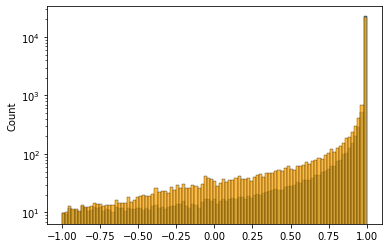

In [35]:
sns.histplot(x=np.cos(det_ph["arrival_angles"]), weights= abs_weight * wl_weight, bins=np.linspace(-1, 1, 100))
sns.histplot(x=np.cos(det_ph["arrival_angles"]), weights=total_weight, bins=np.linspace(-1, 1, 100), color="orange")
plt.semilogy()

[]

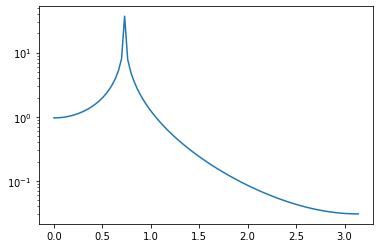

In [22]:
thetas = np.linspace(0, np.pi, 100)
plt.plot(thetas, 
cherenkov_ang_dist(np.cos(thetas - 0), n_ph=cascadia_ref_index_func(700))
                / cherenkov_ang_dist_int(cascadia_ref_index_func(700), -1, 1)
                * 2
)
plt.semilogy()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


10004.636858685975


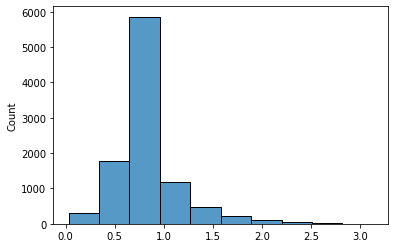

In [20]:
a = np.arccos(np.random.uniform(-1, 1, size=10000))
w = (
    cherenkov_ang_dist(np.cos(a - 0), n_ph=cascadia_ref_index_func(700))
                / cherenkov_ang_dist_int(cascadia_ref_index_func(700), -1, 1)
                * 2)
sns.histplot(x=a, weights=w)

print(np.sum(w))

In [21]:
w

array([0.11430867, 1.28567841, 0.51839896, ..., 0.06136814, 0.07209044,
       0.19610162])

<AxesSubplot:ylabel='Count'>

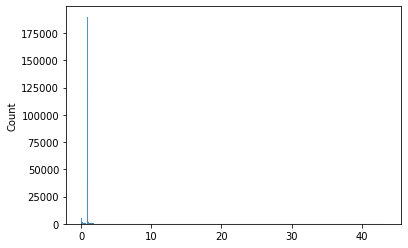

In [14]:
sns.histplot(c_weight, bins=1000)